# [IAPR 2019:][iapr2019] Special project

**Group members:**
    1- first name and last name,
    2- first name and last name,
    3- first name and last name

**Due date:** 30.05.2019

[iapr2019]: https://github.com/LTS5/iapr-2019


## Description
Please find the description of this special project via [this link].

[this link]: https://github.com/LTS5/iapr-2019/blob/master/project/special_project_description.pdf

## Part 1: Finding varroas by segmentation
Add your implementation for ''**detect_by_segmentation**'' function. Please make sure the input and output follows the mentioned format.

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

In [1]:
from PIL import Image
import glob
import os
import cv2
import skimage.io
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import matplotlib.patches as mpatches
from skimage.filters import threshold_minimum
from skimage.filters import threshold_otsu
import numpy as np
from skimage.segmentation import clear_border
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
import random
import pandas as pd
import xml.etree.ElementTree as ET



In [2]:
# get the parent directory
data_base_path = os.path.join(os.pardir, 'data') 
#initialize this list to save all the train images
image_list = []

#uploas the 800 images of the train set
for filename in sorted(glob.glob(data_base_path+'/project-data/images/train/*.jpg')):# put sorted otheriwse the order is arbitrary!!
    im=cv2.imread(filename)
    image_list.append(im)

In [3]:
#uploas the 50 images of the test set
image_test_list=[]
for filename in sorted(glob.glob(data_base_path+'/project-data/images/test/*.jpg')[0:50]):# put sorted otheriwse the order is arbitrary!!
    im=cv2.imread(filename)
    image_test_list.append(im)


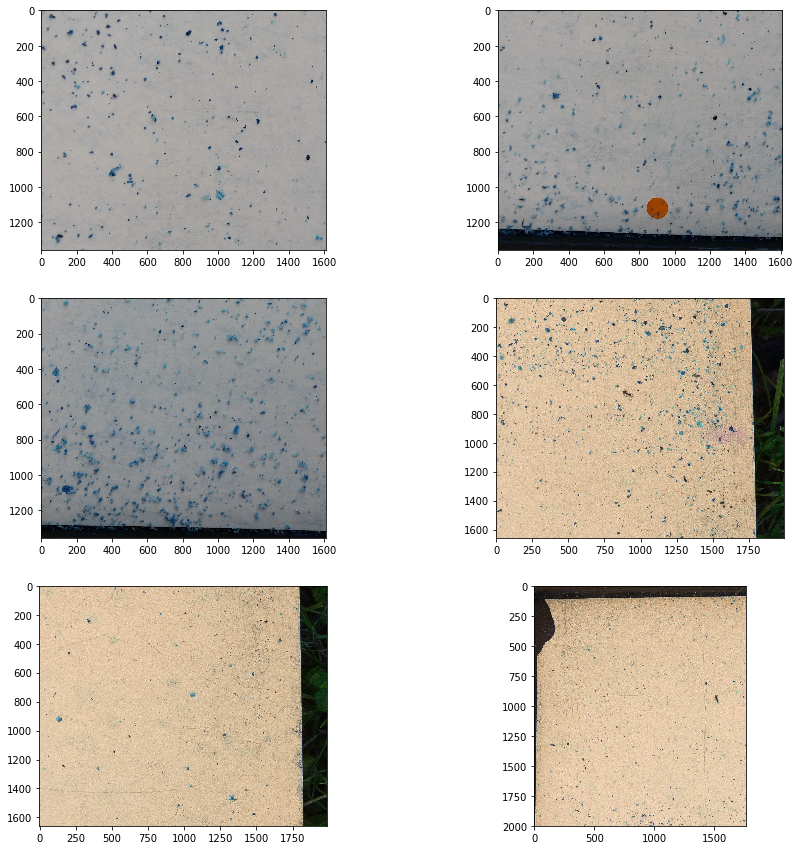

In [6]:
#look at some images in the train set:
nb_image=6
_,axes=plt.subplots(3,2,figsize=(15,15))
for i,ax,image in zip(range(nb_image),axes.ravel(),image_list[0:6]):
    
    ax.imshow(image)
plt.show()

In [7]:
#function for reading the ground thruth:

def parse_file(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymin').text)),
                              int(float(bbox.find('xmax').text))-int(float(bbox.find('xmin').text)),
                              int(float(bbox.find('ymax').text))-int(float(bbox.find('ymin').text))]
        objects.append(obj_struct)

    return objects

In [8]:
#extract the labels for the test and train set:
annotations_xmls=[parse_file(filename) for filename in sorted(glob.glob(data_base_path+'/project-data/annotations/train/*.xml'))]
annotations_test_xmls=[parse_file(filename) for filename in sorted(glob.glob(data_base_path+'/project-data/annotations/test/*.xml'))]

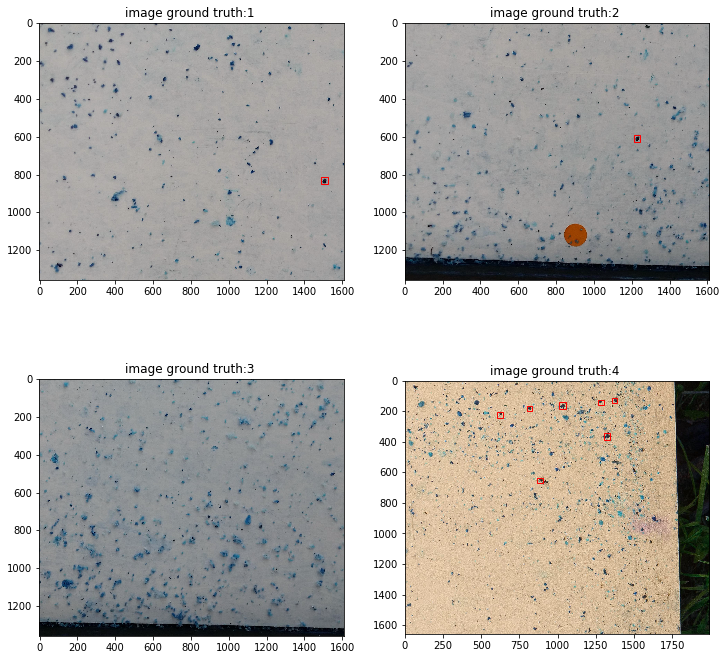

In [11]:
#look at the ground truth for 6 images in the training set
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
i=0
#just take the first 6 image and look where the varroa is...
annotations_red=annotations_xmls[0:4]
for ax,annotations in zip(axes.ravel() , annotations_red):
    
    # Iterate over annotations
    for anno in annotations:
        
        rect = mpatches.Rectangle((anno['bbox'][0], anno['bbox'][1]), anno['bbox'][2], anno['bbox'][3],
                linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
   
    ax.imshow(image_list[i])
    i+=1
   
    ax.set_title('image ground truth:{} '.format(i))
plt.show()

The approach we decide to use for defining the threshold is the following:

1) let's look at the varroa boxes for each images of the training set

2) appling a threshold for each of these boxes in order to distinguish foreground from background

3) keep all the threshold ( 3 threshold for the three channels) and average them

4) the lower bound for the final threshold would be [0,0,0] and the upper bound is the average threshold found in point 3)

Another important consideration should be done for the varroa's area.
In fact, as we select the varroa's boxes from each training image and applying the threhsold, we label the regions found and we took the second biggest region as a representation of the varroa's area. The final area is the average +/- 1 standard deviation of the total areas.


In [13]:
#function that defines the threshold for each image of the training set: otsu method was choosen
def find_threshold(image):
    thresh_min = threshold_otsu(image)
    
    return thresh_min

In [14]:
#in this function we go through all the images and keeping the region where the varroa is present,  
#applying the threshold for each of the three channels and calculating the varroa's area(as the region 
#with second biggest area : the first one is the background )

def calculate_value_of_interest(image, x,y,width,height):
    min_value,max_value=0,0
    threshold=[]
    area=0
    #define the area of interest
    image_corr=image[y:y+height,x:x+width,:]
    #threshold for each of thre channel
    for j in range(3):
        threshold.append(find_threshold(image_corr[:,:,j]))
    lower_color_bounds = np.array([0, 0, 0],dtype = "uint8")
    upper_color_bounds = np.asarray(threshold).astype('uint8')

    #label the region found by the thresholding method and took the second biggest as representing the varroa
    mask = cv2.inRange(image_corr,lower_color_bounds,upper_color_bounds )
    label_image = label(mask)
    
    area=np.sort(np.bincount(label_image.flat))[::-1][1]
    
    return threshold,area

In [16]:
# in this cell we are going to print the resulting average threshold and varroa's area with their 
#standard deviation. In the same time also the varroa's boxes area is calculated.

threshold=[]
area=[]
area_box=[]
ground_truth={}

for i,annotations in enumerate(annotations_xmls):
    true_values=[]
   
    for anno in annotations:
            
            #labels
            true_values.append([anno['bbox'][0],anno['bbox'][1],anno['bbox'][0]+anno['bbox'][2],anno['bbox'][1]+anno['bbox'][3]])
            #varroa's boxes area
            area_box.append([anno['bbox'][2]*anno['bbox'][3]])
            #threshold and area of the varroa
            thresh,area_=calculate_value_of_interest(image_list[i],anno['bbox'][0],anno['bbox'][1],anno['bbox'][2],anno['bbox'][3])
            
            threshold.append(thresh)
            area.append(area_)
    #dictionatu containing all the labels     
    ground_truth[str(i)]=[]
    ground_truth[str(i)].append(true_values)
        

resulting_threshold=np.mean(threshold,axis=0).round()  
area_final=np.mean(area).round()
print('the resulting threshold is  {} +/- {} '.format(resulting_threshold,np.std(threshold,axis=0).round()))
print('the resulting area is  {} +/- {} '.format(area_final,np.std(area).round()))


the resulting threshold is  [86. 86. 95.] +/- [30. 24. 23.] 
the resulting area is  329.0 +/- 166.0 


In [307]:
#this is how the label are saved for the training set images:
ground_truth

{'0': [[[1490, 815, 1524, 849]]],
 '1': [[[1210, 593, 1243, 626]]],
 '2': [[]],
 '3': [[[1267, 125, 1305, 159],
   [797, 164, 832, 200],
   [868, 634, 903, 668],
   [605, 207, 640, 245],
   [1356, 116, 1390, 149],
   [1010, 141, 1053, 185],
   [1303, 343, 1346, 387]]],
 '4': [[]],
 '5': [[[1410, 794, 1443, 833]]],
 '6': [[[939, 469, 967, 495],
   [1023, 644, 1059, 682],
   [1369, 526, 1404, 561],
   [1468, 892, 1501, 926],
   [1703, 1545, 1737, 1582],
   [1391, 948, 1431, 985],
   [1023, 1819, 1060, 1857],
   [451, 1249, 484, 1283],
   [1569, 1155, 1603, 1190],
   [1641, 1456, 1677, 1494],
   [1313, 759, 1351, 803],
   [879, 412, 915, 451],
   [1455, 907, 1490, 945]]],
 '7': [[]],
 '8': [[[858, 388, 892, 428],
   [440, 1339, 476, 1373],
   [42, 1484, 76, 1519],
   [151, 1045, 187, 1079],
   [1508, 1833, 1544, 1867],
   [244, 1793, 278, 1831],
   [905, 1598, 940, 1632],
   [716, 1929, 752, 1963],
   [1191, 1910, 1226, 1952],
   [630, 1240, 666, 1277],
   [709, 1844, 743, 1877],
   [756,

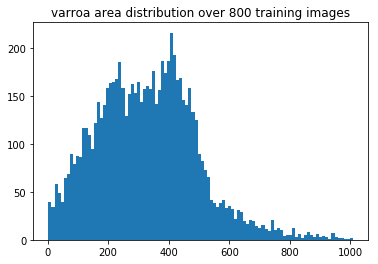

In [22]:
plt.hist(area, 100)
plt.title('varroa area distribution over 800 training images')
plt.show()

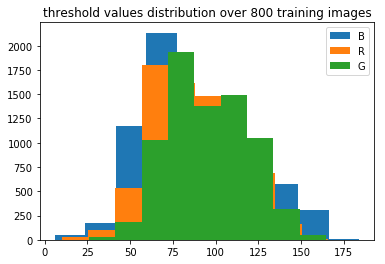

In [19]:
channel1,channel2,channel3=[],[],[]
for thresh in (threshold):
    
    channel1.append(thresh[0])
    channel2.append(thresh[1])
    channel3.append(thresh[2])
    
plt.hist(channel1)
plt.hist(channel2)
plt.hist(channel3)
plt.title('threshold values distribution over 800 training images')
plt.legend(['B','R','G'])
plt.show()

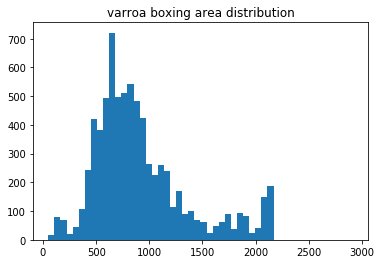

In [23]:
plt.hist(np.asarray(area_box),bins=50)
plt.title('varroa boxing area distribution')
plt.show()

In [25]:
print('median area boxes: {}'.format(np.median(area_box)))

median area boxes: 812.0


In [64]:
def detect_by_segmentation(image_test_list,resulting_threshold,area_final,area):
    '''
    Input: One single imagevia catona
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    lower_color_bounds=np.array([0,0,0],dtype='uint8')
    upper_color_bounds = resulting_threshold.astype('uint8')
    
    
    prediction=[]
   
    
    #applying th thresholding
    mask = cv2.inRange(image_test_list,lower_color_bounds,upper_color_bounds )
    #remove artifacts connected to image border--> a lot of false positive at the border
    cleared = mask.copy()
    clear_border(cleared)

    # label image regions
    label_image = label(cleared)
    borders = np.logical_xor(mask, cleared)
    label_image[borders] = -1
    
    

    for region in regionprops(label_image):
   
        #area should be higher than the average area -std of the area and less than the average area +std
        if (region.area >= area_final-np.std(area).round()) & (region.area <= area_final+2*np.std(area).round()):
      
            minr, minc, maxr, maxc = region.bbox
            prediction.append([minc,minr,maxc,maxr])
    
    
    

    return np.asarray(prediction)
    #Your code

Let's apply the final threshold and consider the varroa's area that is in the inverval of [final_area-1 std, final_area +2std] for the 50 test images. The box predictions are saved in a dictionary : pred.


In [65]:
pred={}

#1 attempt: consider as threshold the average found before
lower_color_bounds=np.array([0,0,0],dtype='uint8')
upper_color_bounds = resulting_threshold.astype('uint8')


for i in range(len(image_test_list)):
    print('nb of image:{}'.format(i))
    pred[str(i)]=[]
    prediction=detect_by_segmentation(image_test_list[i],resulting_threshold,area_final,area)
    


    pred[str(i)].append(list(prediction))

nb of image:0
nb of image:1
nb of image:2
nb of image:3
nb of image:4
nb of image:5
nb of image:6
nb of image:7
nb of image:8
nb of image:9
nb of image:10
nb of image:11
nb of image:12
nb of image:13
nb of image:14
nb of image:15
nb of image:16
nb of image:17
nb of image:18
nb of image:19
nb of image:20
nb of image:21
nb of image:22
nb of image:23
nb of image:24
nb of image:25
nb of image:26
nb of image:27
nb of image:28
nb of image:29
nb of image:30
nb of image:31
nb of image:32
nb of image:33
nb of image:34
nb of image:35
nb of image:36
nb of image:37
nb of image:38
nb of image:39
nb of image:40
nb of image:41
nb of image:42
nb of image:43
nb of image:44
nb of image:45
nb of image:46
nb of image:47
nb of image:48
nb of image:49


In [35]:
#these are the predction values for the test set:
pred

{'0': [[[826, 351, 849, 365], [572, 1213, 589, 1230], [646, 1297, 663, 1312]]],
 '1': [[[344, 11, 368, 26],
   [1121, 31, 1137, 51],
   [607, 56, 644, 78],
   [846, 61, 872, 83],
   [778, 85, 815, 106],
   [1680, 91, 1698, 117],
   [769, 97, 783, 120],
   [166, 101, 195, 121],
   [256, 106, 278, 126],
   [1256, 114, 1280, 129],
   [1430, 146, 1448, 164],
   [241, 147, 263, 169],
   [0, 157, 19, 186],
   [520, 159, 542, 179],
   [478, 165, 496, 185],
   [1666, 167, 1682, 188],
   [1404, 183, 1430, 205],
   [896, 188, 912, 210],
   [50, 193, 69, 214],
   [182, 201, 212, 219],
   [214, 206, 233, 227],
   [1174, 235, 1190, 258],
   [259, 262, 278, 280],
   [1552, 262, 1587, 296],
   [33, 301, 57, 319],
   [258, 306, 279, 329],
   [359, 343, 376, 365],
   [693, 344, 715, 363],
   [715, 348, 739, 365],
   [400, 349, 419, 366],
   [675, 357, 691, 380],
   [1383, 358, 1401, 379],
   [846, 387, 865, 409],
   [701, 389, 721, 409],
   [649, 394, 669, 414],
   [1522, 417, 1539, 441],
   [1039, 433

In [36]:
#let's gather the labels for the test_set:
ground_test_truth={}

for i,annotations in enumerate(annotations_test_xmls):
    true_values=[]
   
    for anno in annotations:
            
            #labels
            true_values.append([anno['bbox'][0],anno['bbox'][1],anno['bbox'][0]+anno['bbox'][2],anno['bbox'][1]+anno['bbox'][3]])
            
           
    #dictionatu containing all the labels     
    ground_test_truth[str(i)]=[]
    ground_test_truth[str(i)].append(true_values)
        

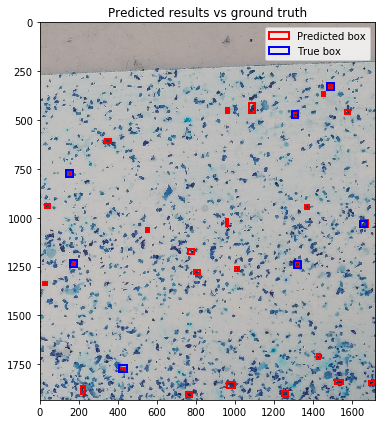

In [66]:
#let's have one plot displaying the prediction and the real truth for one images of the test set:
number=9


fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_test_list[number])

for values in pred[str(number)][0]:        

        rect = mpatches.Rectangle((values[0], values[1]),values[2]-values[0], values[3]-values[1],
                                  fill=False, edgecolor='red', linewidth=2,label='Predicted box')
        ax.add_patch(rect)


        
for values in ground_test_truth[str(number)][0]:
    rect2=mpatches.Rectangle((values[0], values[1]),values[2]-values[0], values[3]-values[1],
                                  fill=False, edgecolor='blue', linewidth=2,label='True box')
       
    ax.add_patch(rect2)
plt.legend(handles=[rect,rect2])


plt.title('Predicted results vs ground truth')

plt.tight_layout()
plt.show()

In [40]:
#function evaluating the intersection over union:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = (xB - xA) * (yB - yA)

    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    # return the intersection over union value
    return round(iou,1)

In [42]:
#function evaluating if two images intersect :
def verify_intersection(real_value,prediction):
    if ((real_value[0]<prediction[2]) & (prediction[0]<real_value[2]) & (real_value[3]>prediction[1]) & (real_value[1]<prediction[3])):
        return True

In [73]:
#evaluating the I0U for all the 50 test_images:
threshold=0.3
tp,fp,fn=0,0,0

for i in range( len(ground_test_truth.keys())):
    print('nb of image:{}'.format(i))
    df=pd.DataFrame(index=range(len(ground_test_truth[str(i)][0])), columns=range(len(pred[str(i)][0])))
    for  k,real_value in enumerate(ground_test_truth[str(i)][0]):

        for j,prediction in enumerate(pred[str(i)][0]):#for each prediction let's calculate the IoU respect to each target

                if verify_intersection(real_value,prediction) :
                       iou=bb_intersection_over_union(prediction,real_value)
                       df.loc[k,j]=iou
                else :

                    df.loc[k,j]=0
     #counting the number of true positive, false postive nd false negative               
    tp+=np.sum(df.max(axis=1)>=threshold)
    fp+=np.sum(df.max(axis=0)<threshold)
    fn+=np.sum(df.max(axis=1)<threshold)

nb of image:0
nb of image:1
nb of image:2
nb of image:3
nb of image:4
nb of image:5
nb of image:6
nb of image:7
nb of image:8
nb of image:9
nb of image:10
nb of image:11
nb of image:12
nb of image:13
nb of image:14
nb of image:15
nb of image:16
nb of image:17
nb of image:18
nb of image:19
nb of image:20
nb of image:21
nb of image:22
nb of image:23
nb of image:24
nb of image:25
nb of image:26
nb of image:27
nb of image:28
nb of image:29
nb of image:30
nb of image:31
nb of image:32
nb of image:33
nb of image:34
nb of image:35
nb of image:36
nb of image:37
nb of image:38
nb of image:39
nb of image:40
nb of image:41
nb of image:42
nb of image:43
nb of image:44
nb of image:45
nb of image:46
nb of image:47
nb of image:48
nb of image:49


we really need to pay attention when considering the area of the varroa according the ground truth! in fact the label boxes are not precsing defining the varroa's area but as well they include a lot of empty space!!! this would bring to lower IoU results.

In [77]:
print('true positive:{} ,false positive:{} ,false negative:{}'.format(tp,fp,fn))

true positive:363 ,false positive:2776 ,false negative:209


In [78]:
print('precision',tp/(tp+fp))
print('recall',tp/(tp+fn))
print('F1',( 2*tp/(tp+fn) * tp/(tp+fp) )/(tp/(tp+fp)+tp/(tp+fn)))

precision 0.11564192417967506
recall 0.6346153846153846
F1 0.19563459983831852


## Part 2: Implement your first detector

Write your function(s) for the second part. Feel free to change the name of the function and add your additional functions, but please make sure their input and output follows the mentioned format.

In [26]:
def detect_by_method_1(img):
    '''
    Input: One single image
    Output: A numpy array containing coordonates of all detected varroas, with the following format: 
            [[x_1, y_1, w_1, h_2], [x_2, y_2, w_1, h_2], ..., [x_n, y_n, w_n, h_n]] 
            where ''n'' is the number of detected varroas.
    '''

    #Your code

The idea here is to construct the features starting from the varroas' box. Let's just consider 50 train images ( as a first starting point) and compute some useful features extractors like HOG, haralick and pixel of histogram ?

each varroa box for each image ?

In [82]:
def featureExtractor(image_varroa):
   
        
    fd, hog_image = hog(image_varroa, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1),block_norm= 'L2', visualize=True, multichannel=True)

    gray = cv2.cvtColor(image_varroa, cv2.COLOR_BGR2GRAY)
    #textures = mt.features.haralick(gray.astype('int'))--> this descriptor doesn't work, can install the packadge

            # take the mean of it and return it
    #ht_mean = textures.mean(axis=0)

    feature = cv2.HuMoments(cv2.moments(gray)).flatten() #7 moments invariant to traslation, rotation and scale..
    return fd,feature

In [79]:
def resize_image(flatten,image,new_height=40,
                 new_width=40,
                 method=cv2.INTER_LANCZOS4):
    
    image=image[flatten[1]:flatten[3],flatten[0]:flatten[2],:]
    dim=(new_width, new_height)        
    new_image = cv2.resize(image,dim,interpolation= method)  
    
    return new_image

In [40]:
#better to do downsampling or upsampling ?
#def create_image(flatten,image):#resize the window image
#    
 #   
  #  
    
    
    #if (flatten[3]-flatten[1])>47 :
     #   value_to_remove=round(((((flatten[3]-flatten[1])/47)-1)*(47))/2)
      #  flatten[3]=flatten[3]-value_to_remove-1#for even number
       # flatten[1]=flatten[1]+value_to_remove
    #elif (flatten[2]-flatten[0])>47:  
     #   value_to_remove=round(((((flatten[2]-flatten[0])/47)-1)*(47))/2)
      #  flatten[2]=flatten[2]-value_to_remove-1
       # flatten[0]=flatten[0]+value_to_remove
        
    #elif (flatten[3]-flatten[1])<33 :  
     #  
      #  value_to_add=round((((33/(flatten[3]-flatten[1]))-1)*(flatten[3]-flatten[1]))/2)
       # flatten[3]=flatten[3]+value_to_add
        #flatten[1]=flatten[1]-value_to_add-1
        
    #elif (flatten[2]-flatten[0])<33:  
        
     #   value_to_add=round((((33/(flatten[2]-flatten[0]))-1)*(flatten[2]-flatten[0]))/2)
      #  flatten[0]=flatten[0]-value_to_add
       # flatten[2]=flatten[2]+value_to_add+1
        
   # return image[flatten[1]:flatten[3],flatten[0]:flatten[2],:]

In [285]:
def extract_false_example(image,nb_false_ex,Random=False):
    
    if Random:
        portion_size=random.randint(33, 47)# this number should allow us to always have the same number of Hog features!!
    else:
        portion_size=40
    image_size = (image.shape[0],image.shape[1])
    images=[]
    #nb_false_ex=np.sum(labels)-(len(labels)-np.sum(labels))
    for i in range(nb_false_ex):#number of the false_example--> to be decided 
        

        x1 = random.randint(0, image_size[0]-portion_size-1)
        y1 = random.randint(0, image_size[1]-portion_size-1)
        
        x2, y2 = x1+portion_size, y1+portion_size

        images.append(image[x1:x2,y1:y2,:])

    return images


In [91]:
from skimage.feature import hog

#import mahotas as mt

#take some feautures descriptors from class 1( yes varroa)
Ho_moments=[]
hog_feature=[]
labels=[]
for i,values in enumerate((list(ground_truth.values())[0:124])):
    if len(values[0])!=0: #class 1 yes varroa
        flatten =  [item for sublist in values for item in (sublist) ]
        image_varroa=[resize_image(pixels,image_list[i])   for pixels in (flatten)]
        for single_image in image_varroa:
            feat1,feat2=featureExtractor(single_image)
            hog_feature.append(feat1)
            Ho_moments.append(feat2)
            labels.append(1)
    else: #class 0 no varroa
        image_varroa=extract_false_example(image_list[i],labels,Random=True)
        for single_image in image_varroa:
            feat1,feat2=featureExtractor(single_image)
            hog_feature.append(feat1)
            Ho_moments.append(feat2)
            labels.append(0)
    
    
total_features=np.hstack([hog_feature, Ho_moments])

In [129]:

scaler = MinMaxScaler(feature_range=(0, 1))
#Normalize The feature vectors...
rescaled_features = scaler.fit_transform(total_features)
clf_svm = SVC(gamma='scale',probability=True)
clf_svm.fit(total_features, labels)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [ ]:
#rerun the training for the false positive you will find in the training images-->hard negative mining !!!

In [ ]:
#test on unseen data by sliding window and calculate the recall, precision an f1 (confusion matrix import)

In [81]:
def running_slide_window(images,stepSize,windowSize):
    nb_of_x_steps=np.floor((image.shape[1]-windowSize)/stepSize).astype('int')
    nb_of_y_steps=np.floor((image.shape[0]-windowSize)/stepSize).astype('int')
    for y in range( nb_of_y_steps):
        for x in range( nb_of_x_steps):
            yield ( stepSize*x,stepSize*y,image[stepSize*y:stepSize*y + windowSize, stepSize*x:stepSize*x + windowSize])

In [280]:
rectangle_values={}
for i,images in enumerate(image_list[136:137]):#4 images as test set
    rectangle_values[str(i)]=[]
    
    size_window=random.randint(33, 47) #for each image there is a different size of window
    for (x,y,window) in running_slide_window(images,3,size_window):
        feat1,feat2=featureExtractor(window)
        
        test_features=np.hstack([feat1, feat2])
        #apply classifier
        test_features = scaler.fit_transform(test_features.reshape(1, -1))
        prediction=clf_svm.predict_proba(test_features)
        
        #keep prediction=1

        if prediction[0][1]>0.9:#doesn't work svm !!! no idea why
            rectangle_values[str(i)].append([x,y,size_window])

NameError: name 'hog' is not defined

In [ ]:
#max-suppression algorithm: first IOU , delete window with high intersection , final result !!

Add your implementation. Report the Precision, Recall and F1-score, by using all 50 images of the test-set, and considering 0.3 as the IoU threshold.

## Part 3: Using MLP and CNNs

Add your implementation for the thrid part. Feel free to add your desirable functions, but please make sure you have proper functions for the final detection, where their input and output follows the same format as the previous parts.

In [180]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization, Activation
from keras.optimizers import SGD, Adam
import random
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In order to train our first neural network we need to have an equal portion of negative and positive classes.
We have decided to remove from the dictionary of the ground truth labels the images that not presented  any varroas. 



In [181]:
varroa_images=ground_truth.copy()
no_varroa_images=[]
for i in range(len(ground_truth)):
    if len(ground_truth[str(i)][0])==0:
        del varroa_images[str(i)]
        no_varroa_images.append(i)
   

From now on, we consider 'varroa_images' as the dictionary containing all the images with varroa and 'no_varroa_images' as a list containing all the number of images without any varroas. We realised that there are more images containing the varroa: 532 vs 268.
In order to take into account all the training images, we count how many varroas were detected in the 532 images and we randomly select the same number of images from the 268 negative samples.

Another key feature concerns the fact that all the training images were resized to [30*30] considering the fact that the median value of the varroa's boxes area is 812 for the 800 training images.

In [182]:
print('images not containing the varroa : {}'.format(len(no_varroa_images)))
print('images containing the varroa : {}'.format(len(varroa_images)))

images not containing the varroa : 268
images containing the varroa : 532


In [183]:
print('median area boxes: {}'.format(np.median(area_box)))

median area boxes: 812.0


In [287]:
def resize_image(image,new_height=40,
                 new_width=40,
                 method=cv2.INTER_LANCZOS4):
    
    
    dim=(new_width, new_height)        
    new_image = cv2.resize(image,dim,interpolation= method)  
    
    return new_image

In [251]:
def concatenate(image,labels,tot_labels,tot_images):
    
    for  values_im,values_lab in zip(image,labels):
        tot_images.append(values_im)
        tot_labels.append(values_lab)
    return (tot_images),tot_labels

In [286]:
def extract_false_example(image,nb_false_ex,Random=False):
    
    if Random:
        portion_size=random.randint(33, 47)# this number should allow us to always have the same number of Hog features!!
    else:
        portion_size=40
    image_size = (image.shape[0],image.shape[1])
    images=[]
    #nb_false_ex=np.sum(labels)-(len(labels)-np.sum(labels))
    for i in range(nb_false_ex):#number of the false_example--> to be decided 
        

        x1 = random.randint(0, image_size[0]-portion_size-1)
        y1 = random.randint(0, image_size[1]-portion_size-1)
        
        x2, y2 = x1+portion_size, y1+portion_size

        images.append(image[x1:x2,y1:y2,:])

    return images



In [288]:
#create the data and the label for the training : METHOD 1

tot_labels_train=[]
tot_images_train=[]
labels=[]
nb_images=len(varroa_images)


#training data from po samples
for i,values in enumerate((list(varroa_images.values())[0:nb_images])):
    
        flatten =  [item for sublist in values for item in (sublist) ]
        image_nb=int(list(varroa_images.keys())[i])
        image_varroa=[resize_image(image_list[image_nb][pixels[1]:pixels[3],pixels[0]:pixels[2],:])   for pixels in (flatten)]
        labels=[1 for j in range(len(image_varroa))]
    
        
        tot_images_train,tot_labels_train=concatenate(image_varroa,labels,tot_labels_train,(tot_images_train))

#numebr of sample to consider from each negative train classes
nb_of_sample=int(np.floor(len(tot_labels_train)/len(no_varroa_images)))

#training data from negative samples
for i in range(len(no_varroa_images)):
    image_varroa=extract_false_example(image_list[no_varroa_images[i]], nb_of_sample)
    labels=[0 for j in range(len(image_varroa))]
    
    tot_images_train,tot_labels_train=concatenate(image_varroa,labels,tot_labels_train,(tot_images_train))

In [289]:
#normalization of the training data
train_set=np.asarray(tot_images_train)/255
train_label=keras.utils.to_categorical(tot_labels_train) 

our neural networks contains 3 Cnn layers with kernel of 5 and 3 with selu activation function and 3 max pool layer with kernel and stride of 2.
The last two layers are 2 fully connected layers. A dropout has been added to avoid overfitting after each layer.
The last activation function is a sigmoid because we are dealing with a 2-class problem

In [308]:
cnnmodel = Sequential()
cnnmodel.add(Conv2D(32, kernel_size = (5,5), activation = 'selu',
            input_shape = (40,40,3)))
cnnmodel.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
#cnnmodel.add(Dropout(0.25))
cnnmodel.add(Conv2D(64, (3, 3), activation='selu'))
cnnmodel.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
#cnnmodel.add(Dropout(0.25))
cnnmodel.add(Conv2D(64, kernel_size = (3,3), activation = 'selu'))
cnnmodel.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
cnnmodel.add(Dropout(0.25))
cnnmodel.add(Flatten())
cnnmodel.add(Dense(200, activation='selu'))
cnnmodel.add(Dropout(0.2))
cnnmodel.add(Dense(2, activation='sigmoid'))

The optimizer is Adam and the loss function is the binary cross entropy , we decide a batch size of 300 and a validation set equal to the 0.3% of the total data. 15 epochs are considered to train the model.

In [309]:
adam = Adam()
cnnmodel.compile(loss = 'binary_crossentropy',
             optimizer = adam,
             metrics = ['accuracy'])
cnnhistory = cnnmodel.fit(train_set, train_label,
         epochs = 15,
         batch_size = 500,
         validation_split = .3,shuffle=True)

Train on 10303 samples, validate on 4416 samples
Epoch 1/15
10303/10303 [==============================] - 79s 8ms/step - loss: 0.2759 - acc: 0.8911 - val_loss: 0.1416 - val_acc: 0.9481
Epoch 2/15
10303/10303 [==============================] - 60s 6ms/step - loss: 0.0874 - acc: 0.9767 - val_loss: 0.0566 - val_acc: 0.9840
Epoch 3/15
10303/10303 [==============================] - 61s 6ms/step - loss: 0.0704 - acc: 0.9803 - val_loss: 0.0859 - val_acc: 0.9753
Epoch 4/15
10303/10303 [==============================] - 60s 6ms/step - loss: 0.0639 - acc: 0.9816 - val_loss: 0.2541 - val_acc: 0.9385
Epoch 5/15
10303/10303 [==============================] - 59s 6ms/step - loss: 0.0784 - acc: 0.9764 - val_loss: 0.0858 - val_acc: 0.9727
Epoch 6/15
10303/10303 [==============================] - 58s 6ms/step - loss: 0.0652 - acc: 0.9813 - val_loss: 0.0630 - val_acc: 0.9818
Epoch 7/15
10303/10303 [==============================] - 56s 5ms/step - loss: 0.0617 - acc: 0.9826 - val_loss: 0.0945 - val_acc:

In [310]:
def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig
def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)


Maximum accuracy: 0.9840353256010491


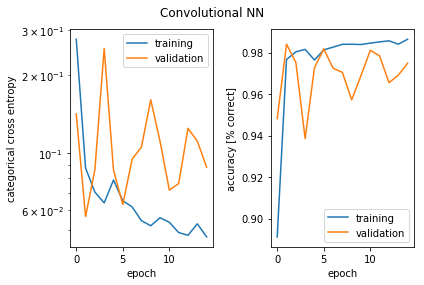

In [311]:
plot_history(cnnhistory, 'Convolutional NN')
print("Maximum accuracy: {}".format(np.max(cnnhistory.history['val_acc'])))

The model is trained considering a sliding window of dimensions 30*30 that slides all the image with a stride set to 3.
A non-max suppression is applied to remove all the overlapping boxeswith IoU of 0.1.
A big brawback of this method concerns the computational cost. We didn't try to merge different size of sliding window.

In [293]:
#this function is useful to create a sliding window through all the image with a stride of 3
def running_slide_window(image,stepSize,windowSize):
    nb_of_x_steps=np.floor((image.shape[1]-windowSize)/stepSize).astype('int')
    nb_of_y_steps=np.floor((image.shape[0]-windowSize)/stepSize).astype('int')
    for y in range( nb_of_y_steps):
        for x in range( nb_of_x_steps):
            yield ( stepSize*x,stepSize*y,image[stepSize*y:stepSize*y + windowSize, stepSize*x:stepSize*x + windowSize])

In [294]:
#this function implements the non max suppression algorithm: basically we sort all the predicted labels according 
#to their probability to detect a varroa and we remove the one with lowest probability that reach a 0.1 IoU overlap.

def nonmax_suppression( value, rectangle_values):
    
    
    rectangle_values=sorted(rectangle_values,key=operator.itemgetter(4),reverse=True)
    
    
    if len(rectangle_values)==1:
        return rectangle_values
    
    
    for i,values in enumerate(rectangle_values):
        rect_copy=rectangle_values[i+1:].copy()
        for second_value in rect_copy:
            if verify_intersection(values,second_value) :
                       iou=bb_intersection_over_union(values,second_value)
                       
                       if (iou >=0.1):
                         
                            rectangle_values.remove(second_value )
                            
    return rectangle_values
                         
 
                           
                             
        

In this section we made our predictions on a random image of the test set. As said before, this method is really computational
inefficient, just thinking that it takes about 15m to run this code on just one image (about 2000*2000 pixels)!
Before calling the algorithm of non-max suppression, another threshold is established of 0.99 to remove the predictions of lower probability

In [312]:
import operator
rectangle_values={}
size_window=40

for i,images in enumerate(image_list[130:131]):# images as test set
    rectangle_values[str(i)]=[]
    #images=cv2.resize(images,dim,interpolation=cv2.INTER_LANCZOS4)
    
    for (x,y,window) in running_slide_window(images,10,size_window):#3 is the stride
        window=np.expand_dims(window,axis=0)
        pred=cnnmodel.predict_proba(window/255)
        
       
        #first thresholding
        if (pred[0][1]>0.999) :
         
            rectangle_values[str(i)].append([x,y,x+size_window,y+size_window,pred[0][1]])
            rectangle_values[str(i)]=nonmax_suppression(pred[0][1],rectangle_values[str(i)])

In [315]:
# 2 method = only cnn no fc for fast computation
cnnmodel = Sequential()
cnnmodel.add(Conv2D(32, kernel_size = (5,5), activation = 'relu',
            input_shape = (None,None,3)))
cnnmodel.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
cnnmodel.add(Conv2D(64, (3, 3), activation='relu'))
cnnmodel.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
cnnmodel.add(Conv2D(64, kernel_size = (3,3), activation = 'relu'))
cnnmodel.add(MaxPooling2D(pool_size=(2, 2),strides=(2,2)))
cnnmodel.add(Dropout(0.25))

cnnmodel.add(Conv2D(576, kernel_size = (3,3), activation = 'relu'))
cnnmodel.add(Dropout(0.25))
cnnmodel.add(Conv2D(100, kernel_size = (1,1), activation = 'relu'))
cnnmodel.add(Conv2D(2, kernel_size = (1,1), activation = 'sigmoid'))



In [316]:
adam = Adam()
cnnmodel.compile(loss = 'binary_crossentropy',
             optimizer = adam,
             metrics = ['accuracy'])
cnnhistory = cnnmodel.fit(train_set, np.expand_dims(np.expand_dims(train_label,axis=1),axis=2),
         epochs = 10,
         batch_size = 500,
         validation_split = .3)

Train on 10303 samples, validate on 4416 samples
Epoch 1/10
10303/10303 [==============================] - 21s 2ms/step - loss: 0.3315 - acc: 0.8472 - val_loss: 0.1546 - val_acc: 0.9374
Epoch 2/10
10303/10303 [==============================] - 17s 2ms/step - loss: 0.0892 - acc: 0.9762 - val_loss: 0.0756 - val_acc: 0.9860
Epoch 3/10
10303/10303 [==============================] - 17s 2ms/step - loss: 0.0876 - acc: 0.9792 - val_loss: 0.1338 - val_acc: 0.9709
Epoch 4/10
10303/10303 [==============================] - 18s 2ms/step - loss: 0.0645 - acc: 0.9842 - val_loss: 0.1395 - val_acc: 0.9649
Epoch 5/10
10303/10303 [==============================] - 19s 2ms/step - loss: 0.0549 - acc: 0.9853 - val_loss: 0.0968 - val_acc: 0.9748
Epoch 6/10
10303/10303 [==============================] - 18s 2ms/step - loss: 0.0573 - acc: 0.9832 - val_loss: 0.1020 - val_acc: 0.9701
Epoch 7/10
10303/10303 [==============================] - 18s 2ms/step - loss: 0.0564 - acc: 0.9832 - val_loss: 0.0894 - val_acc:

In [416]:
def finding_stride(pred,size_window,images):
    
        
    return np.floor((images.shape[1]-size_window)/(pred.shape[0]-1))




In [ ]:
#let's see how the result is performing on the training set:

800

In [419]:
cnn_rectangle_train_values={}
for k,images in enumerate(image_list[0:50]):
    cnn_rectangle_train_values[str(k)]=[]
    images=np.expand_dims(images,axis=0)
    pred=cnnmodel.predict_proba(images/255)
    pred=pred.squeeze()
    pred=pred[:,:,1]
    stride=finding_stride(pred,size_window,images)
    for i in range(pred.shape[0]):
        for j in range(pred.shape[1]):
            if pred[i,j]>0.999: # first filter
                filter_size=[(j)*stride,(i)*stride,(j)*stride+size_window,(i)*stride+size_window,pred[i,j]]
                cnn_rectangle_train_values[str(k)].append(filter_size )
                cnn_rectangle_train_values[str(k)]=nonmax_suppression(pred[i,j],cnn_rectangle_train_values[str(k)])




In [ ]:
#now let's just consider the false positive example for retrain our network!!!

In [427]:
threshold=0.3
tp,fp,fn=0,0,0

#run for the test_images
for i in range( len(list(ground_test_truth.keys())[0:50])):
    print('nb of image:{}'.format(i))
    df=pd.DataFrame(index=range(len(ground_truth[str(i)][0])), columns=range(len(cnn_rectangle_train_values[str(i)])))
    for  k,real_value in enumerate(ground_truth[str(i)][0]):

        for j,prediction in enumerate(cnn_rectangle_train_values[str(i)]):#for each prediction let's calculate the IoU respect to each target

                if verify_intersection(real_value,prediction) :
                       iou=bb_intersection_over_union(prediction,real_value)
                       df.loc[k,j]=iou
                else :

                    df.loc[k,j]=0
     #counting the number of true positive, false postive nd false negative               
    #tp+=np.sum(df.max(axis=1)>=threshold)
    fp+=np.sum(df.max(axis=0)<threshold)
    
   # fn+=np.sum(df.max(axis=1)<threshold)

nb of image:0
nb of image:1
nb of image:2
nb of image:3
nb of image:4
nb of image:5
nb of image:6
nb of image:7
nb of image:8
nb of image:9
nb of image:10
nb of image:11
nb of image:12
nb of image:13
nb of image:14
nb of image:15
nb of image:16
nb of image:17
nb of image:18
nb of image:19
nb of image:20
nb of image:21
nb of image:22
nb of image:23
nb of image:24
nb of image:25
nb of image:26
nb of image:27
nb of image:28
nb of image:29
nb of image:30
nb of image:31
nb of image:32
nb of image:33
nb of image:34
nb of image:35
nb of image:36
nb of image:37
nb of image:38
nb of image:39
nb of image:40
nb of image:41
nb of image:42
nb of image:43
nb of image:44
nb of image:45
nb of image:46
nb of image:47
nb of image:48
nb of image:49


In [451]:
values_fp=df.loc[:,df.max(axis=0)<threshold].columns.values

In [453]:
cnn_rectangle_train_fp_values={}
i=49
cnn_rectangle_train_fp_values[str(i)]=[]
for k in values_fp:
    
    cnn_rectangle_train_fp_values[str(i)].append(cnn_rectangle_train_values[str(i)][k])

In [424]:
cnn_rectangle_values[str(49)]

[[136.0, 640.0, 176.0, 680.0, 0.9999943],
 [632.0, 128.0, 672.0, 168.0, 0.99999297],
 [56.0, 1248.0, 96.0, 1288.0, 0.99998903],
 [576.0, 1152.0, 616.0, 1192.0, 0.9999889],
 [760.0, 1512.0, 800.0, 1552.0, 0.9999865],
 [896.0, 528.0, 936.0, 568.0, 0.9999821],
 [1280.0, 1512.0, 1320.0, 1552.0, 0.9999821],
 [8.0, 752.0, 48.0, 792.0, 0.9999808],
 [792.0, 1336.0, 832.0, 1376.0, 0.9999807],
 [664.0, 664.0, 704.0, 704.0, 0.9999796],
 [32.0, 552.0, 72.0, 592.0, 0.999979],
 [40.0, 856.0, 80.0, 896.0, 0.99997675],
 [920.0, 64.0, 960.0, 104.0, 0.9999746],
 [416.0, 616.0, 456.0, 656.0, 0.99997187],
 [536.0, 1432.0, 576.0, 1472.0, 0.9999703],
 [0.0, 1336.0, 40.0, 1376.0, 0.99996793],
 [744.0, 32.0, 784.0, 72.0, 0.9999678],
 [72.0, 112.0, 112.0, 152.0, 0.99996316],
 [672.0, 448.0, 712.0, 488.0, 0.9999598],
 [936.0, 1040.0, 976.0, 1080.0, 0.9999567],
 [88.0, 8.0, 128.0, 48.0, 0.9999554],
 [696.0, 400.0, 736.0, 440.0, 0.99994314],
 [448.0, 24.0, 488.0, 64.0, 0.9999428],
 [800.0, 704.0, 840.0, 744.0, 0.

In [421]:
df.max(axis=0)<threshold

0      True
1      True
2     False
3      True
4      True
5      True
6      True
7      True
8      True
9      True
10    False
11     True
12     True
13     True
14     True
15    False
16     True
17     True
18     True
19     True
20     True
21     True
22     True
23     True
24     True
25     True
26     True
27     True
28     True
29     True
      ...  
54     True
55     True
56     True
57     True
58     True
59     True
60     True
61     True
62     True
63     True
64     True
65     True
66     True
67     True
68     True
69     True
70     True
71     True
72     True
73     True
74     True
75     True
76     True
77     True
78     True
79     True
80     True
81     True
82     True
83     True
Length: 84, dtype: bool

#testing

In [405]:
cnn_rectangle_values={}
for k,images in enumerate(image_test_list):
    cnn_rectangle_values[str(k)]=[]
    images=np.expand_dims(images,axis=0)
    pred=cnnmodel.predict_proba(images/255)
    pred=pred.squeeze()
    pred=pred[:,:,1]
    stride=finding_stride(pred,size_window,images)
    for i in range(pred.shape[0]):
        for j in range(pred.shape[1]):
            if pred[i,j]>0.999: # first filter
                filter_size=[(j)*stride,(i)*stride,(j)*stride+size_window,(i)*stride+size_window,pred[i,j]]
                cnn_rectangle_values[str(k)].append(filter_size )
                cnn_rectangle_values[str(k)]=nonmax_suppression(pred[i,j],cnn_rectangle_values[str(k)])



In [411]:
threshold=0.3
tp,fp,fn=0,0,0

#run for the test_images
for i in range( len(ground_test_truth.keys())):
    print('nb of image:{}'.format(i))
    df=pd.DataFrame(index=range(len(ground_test_truth[str(i)][0])), columns=range(len(cnn_rectangle_values[str(i)])))
    for  k,real_value in enumerate(ground_test_truth[str(i)][0]):

        for j,prediction in enumerate(cnn_rectangle_values[str(i)]):#for each prediction let's calculate the IoU respect to each target

                if verify_intersection(real_value,prediction) :
                       iou=bb_intersection_over_union(prediction,real_value)
                       df.loc[k,j]=iou
                else :

                    df.loc[k,j]=0
     #counting the number of true positive, false postive nd false negative               
    tp+=np.sum(df.max(axis=1)>=threshold)
    fp+=np.sum(df.max(axis=0)<threshold)
    fn+=np.sum(df.max(axis=1)<threshold)

nb of image:0
nb of image:1
nb of image:2
nb of image:3
nb of image:4
nb of image:5
nb of image:6
nb of image:7
nb of image:8
nb of image:9
nb of image:10
nb of image:11
nb of image:12
nb of image:13
nb of image:14
nb of image:15
nb of image:16
nb of image:17
nb of image:18
nb of image:19
nb of image:20
nb of image:21
nb of image:22
nb of image:23
nb of image:24
nb of image:25
nb of image:26
nb of image:27
nb of image:28
nb of image:29
nb of image:30
nb of image:31
nb of image:32
nb of image:33
nb of image:34
nb of image:35
nb of image:36
nb of image:37
nb of image:38
nb of image:39
nb of image:40
nb of image:41
nb of image:42
nb of image:43
nb of image:44
nb of image:45
nb of image:46
nb of image:47
nb of image:48
nb of image:49


In [412]:
print('true positive:{} ,false positive:{} ,false negative:{}'.format(tp,fp,fn))

true positive:500 ,false positive:1615 ,false negative:82


In [413]:
print('precision',tp/(tp+fp))
print('recall',tp/(tp+fn))
print('F1',( 2*tp/(tp+fn) * tp/(tp+fp) )/(tp/(tp+fp)+tp/(tp+fn)))

precision 0.2364066193853428
recall 0.8591065292096219
F1 0.3707823507601038


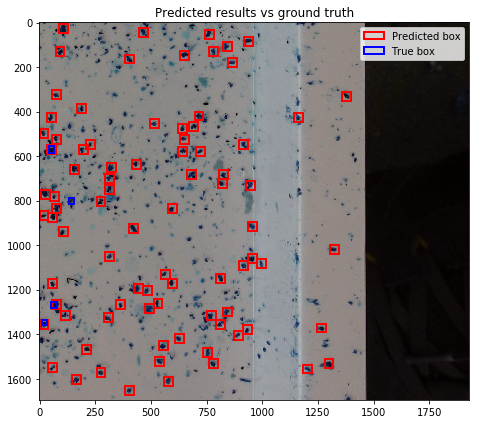

In [415]:
number=49


fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_test_list[number])

for values in cnn_rectangle_values[str(number)]:
        
        
        rect = mpatches.Rectangle((values[0], values[1]), size_window, size_window,
                                  fill=False, edgecolor='red', linewidth=2,label='Predicted box')
        ax.add_patch(rect)


        
for values in ground_test_truth[str(number)][0]:
    rect2=mpatches.Rectangle((values[0], values[1]),values[2]-values[0], values[3]-values[1],
                                  fill=False, edgecolor='blue', linewidth=2,label='True box')
       
    ax.add_patch(rect2)
plt.legend(handles=[rect,rect2])
#pred['1']
#ax.set_axis_off()

plt.title('Predicted results vs ground truth')

plt.tight_layout()
plt.show()

In [ ]:
#try method with encoder and decoders:
# the goal is to give to the decoder a bianry image with one corresponding to the varroa detection:
# the encoder part is the neural network and the decoder it's an upsampling ! will it work ?

In [41]:
#generate the binary images :
import scipy.misc
image_bin_varroa=[]
for i in range(len(image_list)):
  
        images=np.zeros(image_list[i].shape)
    
        for values in ground_truth[str(i)]:
              if len(values)==0:
                
                image_bin_varroa.append(images)
                
                matplotlib.image.imsave('./varroa-binary/'+filename[i],images)
              else:
                    flatten =  [sublist for sublist in values ]#for item in (sublist) ]
                    for pixels in (flatten): images[pixels[0]:pixels[2],pixels[1]:pixels[3],:]=1   
                    
                    
                   
                    image_bin_varroa.append(images)

                    matplotlib.image.imsave('./varroa-binary/'+filename[i],images)
                    

In [40]:
values

[[1490, 815, 1524, 849]]

## Challenge

You can generate a json submission file by using the function ''**generate_pred_json**''. This prediction file can be uploaded online for evaluation (Please refer to section 3 of the project description for more details).

In [ ]:
import numpy as np
import json

def generate_pred_json(data, tag='baseline'):
    '''
    Input
    - data: Is a dictionary d, such that:
          d = { 
              "ID_1": [], 
              "ID_2": [[x_21, y_21, w_21, h_21], [x_22, y_22, w_22, h_22]], 
              ... 
              "ID_i": [[x_i1, y_i1, w_i1, h_i1], ..., [x_iJ, y_iJ, w_iJ, h_iJ]],
              ... 
              "ID_N": [[x_N1, y_N1, w_N1, h_N1]],
          }
          where ID is the string id of the image (e.i. 5a05e86fa07d56baef59b1cb_32.00px_1) and the value the Kx4 
          array of intergers for the K predicted bounding boxes (e.g. [[170, 120, 15, 15]])
    - tag: (optional) string that will be added to the name of the json file.
    Output
      Create a json file, "prediction_[tag].json", conatining the prediction to EvalAI format.
    '''
    unvalid_key = []
    _data = data.copy()
    for key, value in _data.items():
        try:
            # Try to convert to numpy array and cast as closest int
            print(key)
            v = np.around(np.array(value)).astype(int)
            # Check is it is a 2d array with 4 columns (x,y,w,h)
            if v.ndim != 2 or v.shape[1] != 4:
                unvalid_key.append(key)
            # Id must be a string
            if not isinstance(key, str):
                unvalid_key.append(key)
            _data[key] = v.tolist()
        # Deal with not consistant array size and empty predictions
        except (ValueError, TypeError):
            unvalid_key.append(key)
    # Remove unvalid key from dictionnary
    for key in unvalid_key: del _data[key]
    
    with open('prediction_{}.json'.format(tag), 'w') as outfile:
        json.dump(_data, outfile)

In [38]:
#Your code